In [6]:
import requests
import json
import numpy as np
import skfuzzy as fuzzy
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [8]:
restAPI = "https://api.openweathermap.org/data/2.5/onecall?lat=43.2173601&lon=76.6639808&exclude=minutely&units=metric&appid=API_KEY"
response = requests.get(restAPI)
if response.status_code == 200:
    data = response.json()
    report_hourly = data['hourly']
    data_long = len(report_hourly)
    humidity_fc = np.zeros(data_long, dtype='int')
    temperature_fc = np.zeros(data_long)
    precipitation_prob = np.zeros(data_long)
    precipitation_mm = np.zeros(data_long)
    hours = np.arange(0, data_long, 1)
    for i in range(0, data_long):
        humidity_fc[i] = report_hourly[i]['humidity']
        temperature_fc[i] = report_hourly[i]['temp']
        precipitation_prob[i] = report_hourly[i]['pop']*100
else:
    print("Call API Error")

In [21]:
Humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'Humidity')
Temperature = ctrl.Antecedent(np.arange(0, 53 , 1), 'Temperature')
Precipitation_prob = ctrl.Antecedent(np.arange(0, 120, 1), 'Precipitation')
SoilHumRef = ctrl.Consequent(np.arange(0, 101, 1), 'Soil Humidity Reference')

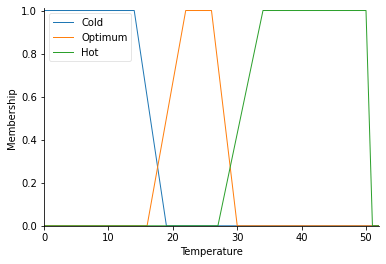

In [10]:
Temperature['Cold'] = fuzzy.trapmf(Temperature.universe,[0, 0, 14, 19])
Temperature['Optimum'] = fuzzy.trapmf(Temperature.universe,[16, 22, 26, 30])
Temperature['Hot'] = fuzzy.trapmf(Temperature.universe,[27, 34, 50, 50])

Temperature.view()

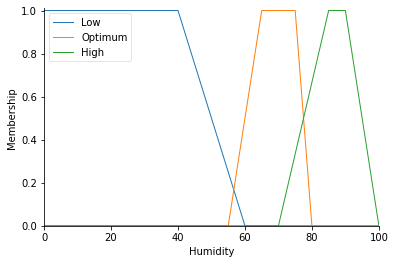

In [11]:
Humidity['Low'] = fuzzy.trapmf(Humidity.universe, [0, 0, 40, 60])
Humidity['Optimum'] = fuzzy.trapmf(Humidity.universe, [55, 65, 75, 80])
Humidity['High'] = fuzzy.trapmf(Humidity.universe, [70, 85, 90, 100])

Humidity.view()

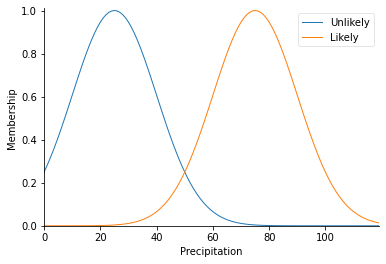

In [12]:
Precipitation_prob['Unlikely'] = fuzzy.gaussmf(Precipitation_prob.universe, 25, 15)
Precipitation_prob['Likely'] = fuzzy.gaussmf(Precipitation_prob.universe, 75, 15)

Precipitation_prob.view()

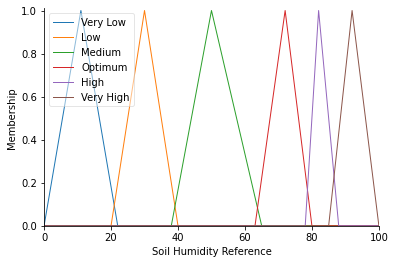

In [13]:
SoilHumRef['Very Low'] = fuzzy.trimf(SoilHumRef.universe, [0, 11, 22])
SoilHumRef['Low'] = fuzzy.trimf(SoilHumRef.universe, [20, 30, 40])
SoilHumRef['Medium'] = fuzzy.trimf(SoilHumRef.universe, [38, 50, 65])
SoilHumRef['Optimum'] = fuzzy.trimf(SoilHumRef.universe, [63, 72, 80])
SoilHumRef['High'] = fuzzy.trimf(SoilHumRef.universe, [78, 82, 88])
SoilHumRef['Very High'] = fuzzy.trimf(SoilHumRef.universe, [85, 92, 100])

SoilHumRef.view()

In [14]:
Rule1 = ctrl.Rule(Humidity['Low'] & Temperature['Cold'] & Precipitation_prob['Likely'], SoilHumRef['Very Low'])
Rule2 = ctrl.Rule(Humidity['Low'] & Temperature['Cold'] & Precipitation_prob['Unlikely'], SoilHumRef['Very Low'])
Rule3 = ctrl.Rule(Humidity['Low'] & Temperature['Hot'] & Precipitation_prob['Likely'], SoilHumRef['Low'])
Rule4 = ctrl.Rule(Humidity['Low'] & Temperature['Hot'] & Precipitation_prob['Unlikely'], SoilHumRef['Very Low'])
Rule5 = ctrl.Rule(Humidity['Low'] & Temperature['Optimum'] & Precipitation_prob['Likely'], SoilHumRef['Low'])
Rule6 = ctrl.Rule(Humidity['Low'] & Temperature['Optimum'] & Precipitation_prob['Unlikely'], SoilHumRef['Low'])

Rule7 = ctrl.Rule(Humidity['High'] & Temperature['Cold'] & Precipitation_prob['Likely'], SoilHumRef['Very Low'])
Rule8 = ctrl.Rule(Humidity['High'] & Temperature['Cold'] & Precipitation_prob['Unlikely'], SoilHumRef['Very Low'])
Rule9 = ctrl.Rule(Humidity['High'] & Temperature['Hot'] & Precipitation_prob['Likely'], SoilHumRef['Medium'])
Rule10 = ctrl.Rule(Humidity['High'] & Temperature['Hot'] & Precipitation_prob['Unlikely'], SoilHumRef['Optimum'])
Rule11 = ctrl.Rule(Humidity['High'] & Temperature['Optimum'] & Precipitation_prob['Likely'], SoilHumRef['Medium'])
Rule12 = ctrl.Rule(Humidity['High'] & Temperature['Optimum'] & Precipitation_prob['Unlikely'], SoilHumRef['Optimum'])

Rule13 = ctrl.Rule(Humidity['Optimum'] & Temperature['Cold'] & Precipitation_prob['Likely'], SoilHumRef['Medium'])
Rule14 = ctrl.Rule(Humidity['Optimum'] & Temperature['Cold'] & Precipitation_prob['Unlikely'], SoilHumRef['Optimum'])
Rule15 = ctrl.Rule(Humidity['Optimum'] & Temperature['Hot'] & Precipitation_prob['Likely'], SoilHumRef['Optimum'])
Rule16 = ctrl.Rule(Humidity['Optimum'] & Temperature['Hot'] & Precipitation_prob['Unlikely'], SoilHumRef['High'])
Rule17 = ctrl.Rule(Humidity['Optimum'] & Temperature['Optimum'] & Precipitation_prob['Likely'], SoilHumRef['High'])
Rule18 = ctrl.Rule(Humidity['Optimum'] & Temperature['Optimum'] & Precipitation_prob['Unlikely'], SoilHumRef['Very High'])

In [15]:
Command_control = ctrl.ControlSystem([Rule1,Rule2,Rule3,Rule4,Rule5,Rule6,Rule7,Rule8,Rule9,Rule10,Rule11,Rule12,Rule13,Rule14,Rule15,Rule16,Rule17,Rule18]) 
SoilHumDecision = ctrl.ControlSystemSimulation(Command_control)

In [16]:
Z = np.zeros(data_long)

for i in range(0, data_long):
    SoilHumDecision.input['Temperature'] = temperature_fc[i]
    SoilHumDecision.input['Humidity'] = humidity_fc[i]
    SoilHumDecision.input['Precipitation'] = precipitation_prob[i]

    SoilHumDecision.compute()
    Z[i] = SoilHumDecision.output['Soil Humidity Reference']

In [17]:
print("Temperature:", temperature_fc[data_long-2], "\nHumidity:", humidity_fc[data_long-2], "\nPrecipitation:", precipitation_prob[data_long-2])

Temperature: -6.47 
Humidity: 89 
Precipitation: 7.000000000000001


Soil Humidity Reference: 11.000 %


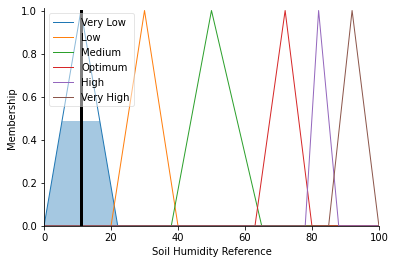

In [18]:
print("Soil Humidity Reference: %.3f" %SoilHumDecision.output['Soil Humidity Reference'], "%")
SoilHumRef.view(sim=SoilHumDecision)

In [19]:
SoilHumDecision.input['Temperature'] = 25
SoilHumDecision.input['Humidity'] = 70
SoilHumDecision.input['Precipitation'] = 80

SoilHumDecision.compute()
print(SoilHumDecision.output['Soil Humidity Reference'])

82.70183210387565


Soil Humidity Reference: 82.702 %


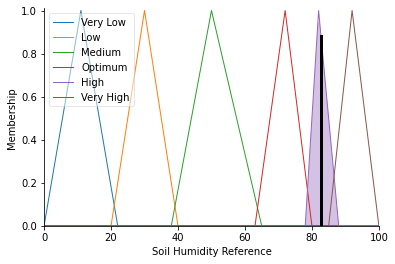

In [20]:
print("Soil Humidity Reference: %.3f" %SoilHumDecision.output['Soil Humidity Reference'], "%")
SoilHumRef.view(sim=SoilHumDecision)